In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torch
import scipy as sp
import json
import numpy as np
from glob import glob
import anndata
import pandas as pd
from src.single_vae import VAE
from src.multi_vae import CrossSpeciesVAE
from src.callbacks import StageAwareEarlyStopping
from src.data import CrossSpeciesDataModule
import pickle
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
import scanpy as sc
import matplotlib.pyplot as plt
import umap
import hnswlib

def _tanh_scale(x,scale=10,center=0.5):
    return center + (1-center) * np.tanh(scale * (x - center))

def _united_proj(wpca1, wpca2, k=20, metric="cosine", ef=200, M=48):

    metric = 'l2' if metric == 'euclidean' else metric
    metric = 'cosine' if metric == 'correlation' else metric
    labels2 = np.arange(wpca2.shape[0])
    p2 = hnswlib.Index(space=metric, dim=wpca2.shape[1])
    p2.init_index(max_elements=wpca2.shape[0], ef_construction=ef, M=M)
    p2.add_items(wpca2, labels2)
    p2.set_ef(ef)
    idx1, dist1 = p2.knn_query(wpca1, k=k)

    if metric == 'cosine':
        dist1 = 1 - dist1
        dist1[dist1 < 1e-3] = 1e-3
        dist1 = dist1/dist1.max(1)[:,None]
        dist1 = _tanh_scale(dist1,scale=10, center=0.7)
    else:
        sigma1 = dist1[:,4]
        sigma1[sigma1<1e-3]=1e-3
        dist1 = np.exp(-dist1/sigma1[:,None])
        
    Sim1 = dist1  # np.exp(-1*(1-dist1)**2)
    knn1v2 = sp.sparse.lil_matrix((wpca1.shape[0], wpca2.shape[0]))
    x1 = np.tile(np.arange(idx1.shape[0])[:, None], (1, idx1.shape[1])).flatten()
    knn1v2[x1.astype('int32'), idx1.flatten().astype('int32')] = Sim1.flatten()
    return knn1v2.tocsr()

from pynndescent import NNDescent

def find_nearest_neighbors(L1, L2, n_neighbors=15, metric='correlation'):
    """
    Finds the nearest neighbors from L1 (query) to L2 (index) using pynndescent.

    Parameters:
        L1 (np.ndarray): Query embeddings of shape (num_queries, embedding_dim).
        L2 (np.ndarray): Index embeddings of shape (num_index, embedding_dim).
        n_neighbors (int): Number of neighbors to find. Default is 5.
        metric (str): Distance metric to use. Default is 'euclidean'.

    Returns:
        indices (np.ndarray): Indices of nearest neighbors in L2 for each query in L1.
        distances (np.ndarray): Distances to nearest neighbors for each query in L1.
    """
    # Validate inputs
    if not isinstance(L1, np.ndarray) or not isinstance(L2, np.ndarray):
        raise ValueError("L1 and L2 must be numpy arrays.")
    
    if L1.shape[1] != L2.shape[1]:
        raise ValueError("L1 and L2 must have the same embedding dimension.")

    # Build the index on L2
    index = NNDescent(L2, metric=metric, n_neighbors=n_neighbors)
    
    # Query the nearest neighbors for L1
    indices, distances = index.query(L1, k=n_neighbors)
    
    return indices, distances

/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
species_data_sub = pickle.load(open('data.p','rb'))

adata1 = species_data_sub['fish']
adata2 = species_data_sub['frog']

batch_size = 256

data_module = CrossSpeciesDataModule(
    species_data = species_data_sub,
    batch_size=batch_size,
    num_workers=0,
    val_split=0.1,
    test_split=0.1,
    yield_pairwise=False,
)
data_module.setup()

species_vocab_sizes = data_module.species_vocab_sizes
homology_edges, homology_scores = pickle.load(open('homology_zfxe.p','rb'))

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=True,
    mode='min'
)


model = CrossSpeciesVAE(
    species_vocab_sizes=species_vocab_sizes,
    homology_edges=homology_edges,
    homology_scores=homology_scores,
    batch_size=batch_size,
    
    # Loss weights
    direct_recon_weight=1.0,
    cross_species_recon_weight=1.0,
    
    # Testing
    n_clusters=100,
    cluster_warmup_epochs=3,
    initial_sigma=2,
    initial_alpha = 0.25,    

    # Learning rate
    base_learning_rate=5e-3,
    min_learning_rate=5e-5,    
    warmup_data=0.1,
    
    # Homology dropout
    homology_dropout_rate=0.2,
    

)

# Initialize the trainer
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=30,
    precision='16-mixed',
    gradient_clip_val=model.gradient_clip_val,
    gradient_clip_algorithm="norm",
    log_every_n_steps=1,
    deterministic=True,
    callbacks=[early_stopping],
    accumulate_grad_batches=1,
    enable_progress_bar=True,
    fast_dev_run=False,
    logger=CSVLogger(
        save_dir="logs",
        name="metrics",
        flush_logs_every_n_steps=10
    )    
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [3]:
trainer.fit(model, data_module)
print(trainer.current_epoch)

You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. I

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.53it/s, v_num=385]        
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 32/32 [00:06<00:00,  5.12it/s, v_num=385]   

Metric val_loss improved. New best score: 0.833


Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.65it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, v_num=385]   

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.800


Epoch 2: 100%|██████████| 32/32 [00:05<00:00,  5.71it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, v_num=385]   

Metric val_loss improved by 0.023 >= min_delta = 0.001. New best score: 0.776


Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.97it/s, v_num=385]   

Metric val_loss improved by 0.017 >= min_delta = 0.001. New best score: 0.759


Epoch 4: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s, v_num=385]   

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.747


Epoch 5: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  5.00it/s, v_num=385]   

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 0.738


Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s, v_num=385]   

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.733


Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.40it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s, v_num=385]   

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.730


Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.30it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  4.94it/s, v_num=385]   

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.727


Epoch 9: 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, v_num=385]   

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.726


Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  4.99it/s, v_num=385]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.723


Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  5.44it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, v_num=385]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.722


Epoch 12: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  5.01it/s, v_num=385]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.721


Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.37it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 32/32 [00:06<00:00,  5.00it/s, v_num=385]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.720


Epoch 15: 100%|██████████| 32/32 [00:05<00:00,  5.35it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 32/32 [00:05<00:00,  5.38it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, v_num=385]  

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.718


Epoch 17: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 32/32 [00:05<00:00,  5.34it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  4.98it/s, v_num=385]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.717


Epoch 19: 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  5.33it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, v_num=385]  

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.716


Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, v_num=385]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  5.36it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 32/32 [00:06<00:00,  5.31it/s, v_num=385]  
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|██████████| 32/32 [00:06<00:00,  4.94it/s, v_num=385]  

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.716. Signaling Trainer to stop.


Epoch 24: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s, v_num=385]
25


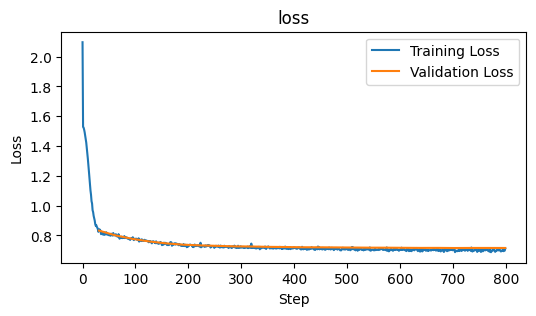

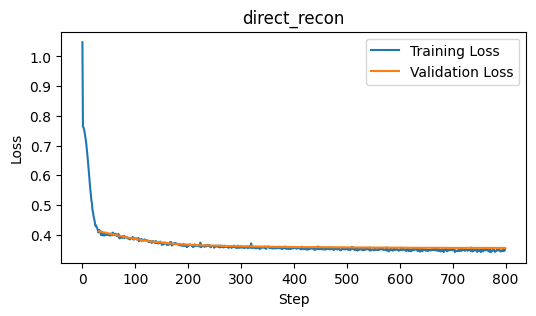

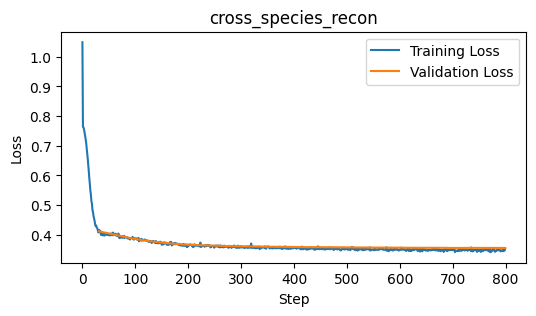

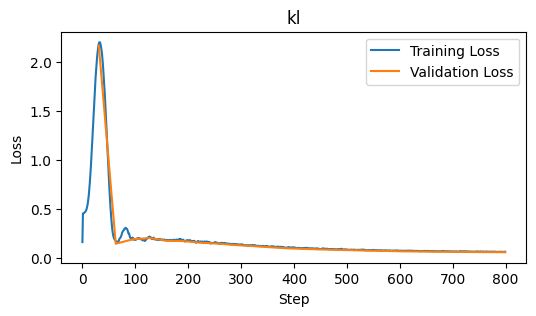

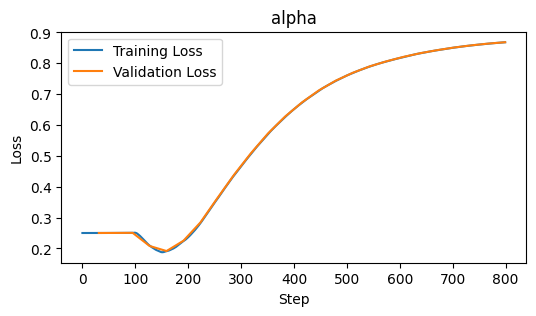

In [4]:
,# Load the latest version
version = max([int(d.split('_')[-1]) for d in glob('logs/metrics/version_*')])
df = pd.read_csv(f'logs/metrics/version_{version}/metrics.csv')


for loss_type in ["loss", "direct_recon", "cross_species_recon", "kl", "alpha"]:
    # Get specific metrics
    train_loss = df[f'train_{loss_type}'][df[f'train_{loss_type}'] != 0.0]
    train_step = df['step'][df[f'train_{loss_type}'] != 0.0]
    f1 = ~train_loss.isna()
    val_loss =  df[f'val_{loss_type}']#[df[f'val_{loss_type}'] != 0.0]
    val_step = df['step']#[df[f'val_{loss_type}'] != 0.0]    
    f2 = ~val_loss.isna()

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 3))
    plt.plot(train_step[f1], train_loss[f1], label='Training Loss')
    plt.plot(val_step[f2], val_loss[f2], label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(loss_type)
    plt.legend()

Species 1 0.36749730826617594 0.6503536544518732
Species 2 0.27442445595928905 0.5792773086984553
Cross species 0.19446500805830455
Cross species 1 0.19672016580288348 0.4686868230142848
Cross species 1 leiden 0.26277217047327395 0.519404718985254
Cross species 2 0.11258992149666366 0.3896871227009352
Cross species 2 leiden 0.22152658503998324 0.5100614327703955


/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


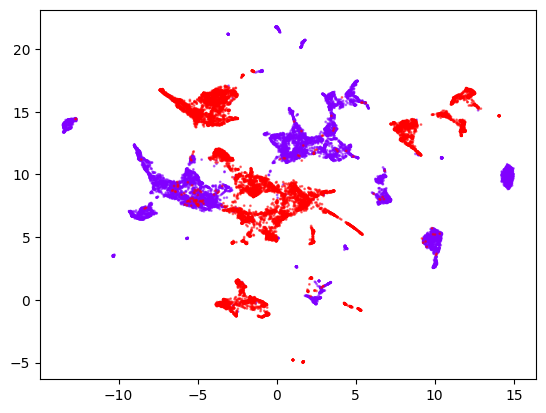

In [5]:
output, s, memberships = model.get_latent_embeddings(species_data_sub, batch_size=4096)
latent = output.cpu().numpy()
s=s.cpu().numpy()

#output, s = model.get_latent_embeddings(species_data)
#s=s.cpu().numpy()

#plt.figure();
#dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
#plt.scatter(dt_full[:,0],dt_full[:,1], c = s,s=5, cmap='rainbow'); plt.colorbar()

for i, adata, key in zip([0, 1], [species_data_sub['fish'], species_data_sub['frog']], ['cell_type', 'cell_type']):
    # dt = dt_full[s==i] # umap.UMAP(n_components=2).fit_transform(output[s==i].detach().cpu().numpy())

    adata.obsm['emb'] = latent[s==i]
    sc.pp.neighbors(adata, use_rep='emb')
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
    print(f"Species {i+1}", adjusted_rand_score(adata.obs[key], adata.obs['leiden']), adjusted_mutual_info_score(adata.obs[key], adata.obs['leiden']))
    
#     plt.figure();
#     plt.scatter(dt[:,0],dt[:,1], c = adata.obs[key].cat.codes,s=5, cmap='rainbow'); plt.colorbar()
    
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')

nnm1v2 = _united_proj(latent[s==0],latent[s==1], k=15, metric='cosine')
nnm2v1 = _united_proj(latent[s==1],latent[s==0], k=15, metric='cosine')

sc.pp.neighbors(adata, use_rep='emb')
adata.obsp['connectivities'] = sp.sparse.vstack((sp.sparse.hstack((sp.sparse.csr_matrix((nnm1v2.shape[0],nnm1v2.shape[0])), nnm1v2)),
sp.sparse.hstack((nnm2v1, sp.sparse.csr_matrix((nnm2v1.shape[0],nnm2v1.shape[0]))))))
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=2)
print("Cross species", adjusted_rand_score(adata.obs['cell_type'], adata.obs['leiden']))

x,y = nnm1v2.nonzero()
cl1 = np.array(list(adata1.obs['cell_type']))
cl2 = np.array(list(adata2.obs['cell_type']))

a = cl2[y.reshape((nnm1v2.shape[0], 15))]
cl1_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl1_new.append(b[np.argmax(v)])

cl1_new = np.array(cl1_new)

print("Cross species 1", adjusted_rand_score(adata1.obs['cell_type'], cl1_new), adjusted_mutual_info_score(adata1.obs['cell_type'], cl1_new))
print("Cross species 1 leiden", adjusted_rand_score(adata1.obs['leiden'], cl1_new), adjusted_mutual_info_score(adata1.obs['leiden'], cl1_new))

x,y = nnm2v1.nonzero()

a = cl1[y.reshape((nnm2v1.shape[0], 15))]
cl2_new = []
for i in range(a.shape[0]):
    b,v = np.unique(a[i],return_counts=True)
    cl2_new.append(b[np.argmax(v)])

cl2_new = np.array(cl2_new)

print("Cross species 2", adjusted_rand_score(adata2.obs['cell_type'], cl2_new), adjusted_mutual_info_score(adata2.obs['cell_type'], cl2_new))
print("Cross species 2 leiden", adjusted_rand_score(adata2.obs['leiden'], cl2_new), adjusted_mutual_info_score(adata2.obs['leiden'], cl2_new))

plt.figure();
dt_full = umap.UMAP(n_components=2).fit_transform(output.detach().cpu().numpy())
plt.scatter(dt_full[:,0],dt_full[:,1],c=s,s=1, alpha=0.5, cmap='rainbow');

In [6]:
c_memberships1 = memberships[0].detach().cpu().numpy()
c1 = np.argmax(c_memberships1,axis=1)

c_memberships2 = memberships[1].detach().cpu().numpy()
c2 = np.argmax(c_memberships2,axis=1)

c = c1

print(adjusted_rand_score(c1,c2))

0.23392569858270798


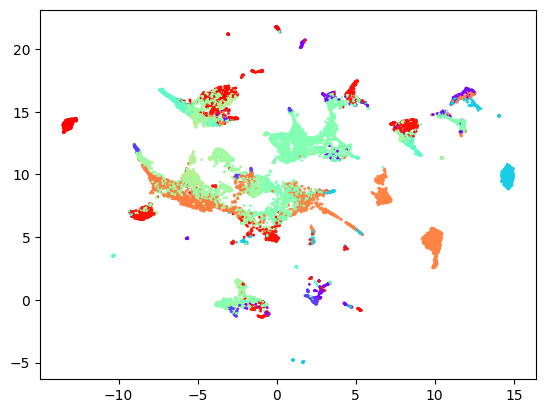

In [7]:
plt.figure(); plt.scatter(dt_full[:,0],dt_full[:,1],c=c1,cmap='rainbow',s=1);

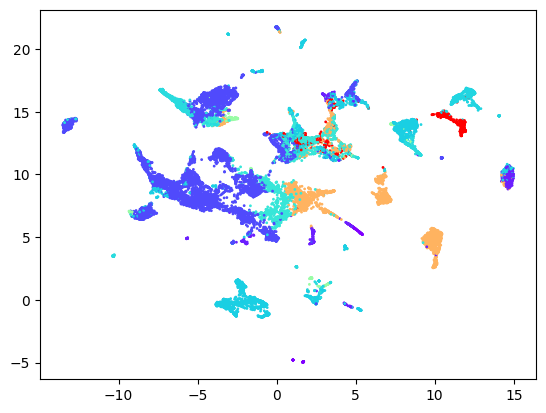

In [8]:
plt.figure(); plt.scatter(dt_full[:,0],dt_full[:,1],c=c2,cmap='rainbow',s=1);

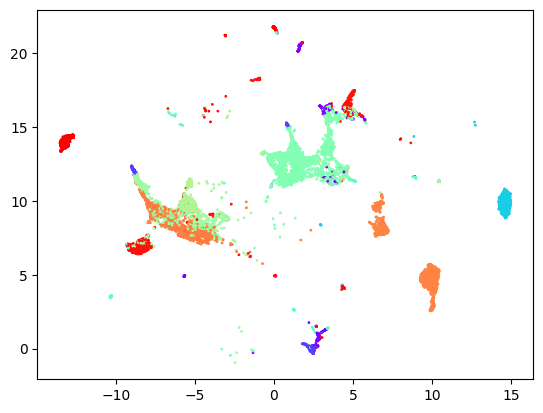

In [9]:
plt.figure(); plt.scatter(dt_full[s==0,0],dt_full[s==0,1],c=c1[s==0],cmap='rainbow',s=1);

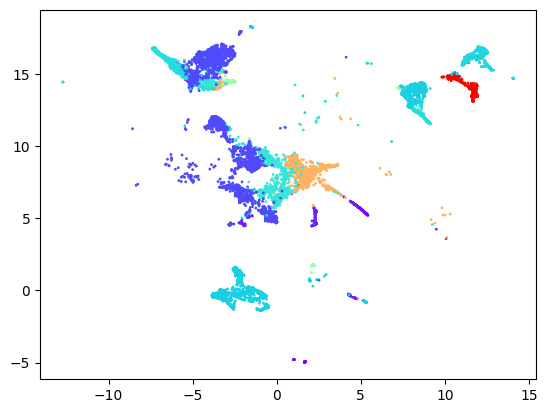

In [10]:
plt.figure(); plt.scatter(dt_full[s==1,0],dt_full[s==1,1],c=c2[s==1],cmap='rainbow',s=1);

In [11]:
from sklearn.metrics import silhouette_score

In [12]:
adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],c1[s==0]), adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],species_data_sub['fish'].obs['leiden'])

(0.4919276347089829, 0.6503536544518732)

In [13]:
adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],c2[s==1]), adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],species_data_sub['frog'].obs['leiden'])

(0.41053804546097394, 0.5792773086984553)

In [14]:
torch.exp(model.clusterers['0'].log_sigma).max(), torch.exp(model.clusterers['0'].log_sigma).min()

(tensor(3.2406, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.3913, device='cuda:0', grad_fn=<MinBackward1>))

In [15]:
torch.exp(model.clusterers['1'].log_sigma).max(), torch.exp(model.clusterers['1'].log_sigma).min()

(tensor(4.5839, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.4371, device='cuda:0', grad_fn=<MinBackward1>))

In [16]:
x,y = np.unique(c2,return_counts=True)
x[y>5].size

10

In [17]:
x,y = np.unique(c1,return_counts=True)
x[y>5].size

11

In [18]:
from sklearn.cluster import KMeans

labels = KMeans(n_clusters=100).fit_predict(output.cpu().numpy())

In [19]:
adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],labels[s==0]), adjusted_mutual_info_score(species_data_sub['fish'].obs['cell_type'],species_data_sub['fish'].obs['leiden'])

(0.6195030332810607, 0.6503536544518732)

In [20]:
adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],labels[s==1]), adjusted_mutual_info_score(species_data_sub['frog'].obs['cell_type'],species_data_sub['frog'].obs['leiden'])

(0.5519328786125127, 0.5792773086984553)

In [21]:
score1 = silhouette_score(output.cpu().numpy(), c)
score2 = silhouette_score(output.cpu().numpy(), labels)
print("Silhouette score model:", score1)
print("Silhouette score reference:", score2)
print("Ratio:", score1/score2)


Silhouette score model: 0.06008414
Silhouette score reference: 0.18989424
Ratio: 0.31640846


In [22]:
z=[]
for i in np.unique(labels):
    v = s[labels==i]
    j = (v==0).mean()
    z.append(max(j,1-j))
    
np.mean(z)

0.9303456255616581

In [23]:
z=[]
for i in np.unique(c):
    v = s[c==i]
    j = (v==0).mean()
    z.append(max(j,1-j))
    
np.mean(z)

0.6462597543134306

In [24]:
latent = output.cpu().numpy()
adatas = []
for i, k in enumerate(species_data_sub):
    adata = species_data_sub[k]
    adata.obsm['emb'] = latent[s==i]
    adata.obs['species'] = k
    adatas.append(adata)

adata = anndata.concat(adatas,join='outer')
adata.obsm['X_umap'] = dt_full

import scanpy as sc

sc.external.pp.harmony_integrate(adata, "species", basis='emb', adjusted_basis='X_pca_harmony')

adata.obsm['X_umap'] = umap.UMAP().fit_transform(adata.obsm['X_pca_harmony'])

2025-01-03 21:56:38,417 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-03 21:56:40,806 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-03 21:56:40,844 - harmonypy - INFO - Iteration 1 of 10
2025-01-03 21:56:44,668 - harmonypy - INFO - Iteration 2 of 10
2025-01-03 21:56:48,629 - harmonypy - INFO - Iteration 3 of 10
2025-01-03 21:56:52,823 - harmonypy - INFO - Iteration 4 of 10
2025-01-03 21:56:57,111 - harmonypy - INFO - Iteration 5 of 10
2025-01-03 21:57:00,918 - harmonypy - INFO - Iteration 6 of 10
2025-01-03 21:57:03,289 - harmonypy - INFO - Iteration 7 of 10
2025-01-03 21:57:05,548 - harmonypy - INFO - Iteration 8 of 10
2025-01-03 21:57:07,950 - harmonypy - INFO - Iteration 9 of 10
2025-01-03 21:57:10,195 - harmonypy - INFO - Iteration 10 of 10
2025-01-03 21:57:12,449 - harmonypy - INFO - Stopped before convergence
/opt/jupyter-envs/generate-cross-species/atar-jupyter/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.p

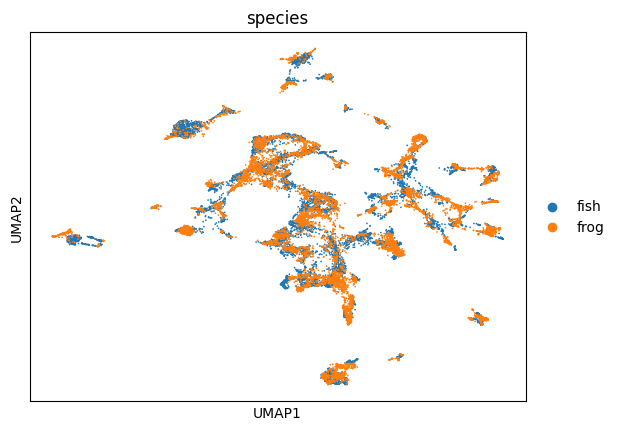

In [25]:
sc.pl.umap(adata,color='species')

In [26]:
def generate_label_similarity_matrix(latent, s, i, j, name1, name2, K):
    nnm = _united_proj(latent[s==j],latent[s==i], k=K, metric='cosine')
    x, y = nnm.nonzero()
    indices_x = x.reshape((nnm.shape[0],K))
    indices_y = y.reshape((nnm.shape[0],K))
    similarities = nnm.data.reshape((nnm.shape[0],K))


    cl1 = np.array(list(species_data_sub['fish'].obs[name1]))
    cl2 = np.array(list(species_data_sub['frog'].obs[name2]))

    clu1,cluc1 = np.unique(cl1, return_counts=True)
    clu2,cluc2 = np.unique(cl2, return_counts=True)

    C = np.zeros((clu1.size,clu2.size))

    
    df = pd.DataFrame();
    df['labels_0'] = cl1[indices_y].flatten()
    df['labels_1'] = cl2[indices_x].flatten()
    df['similarities'] = similarities.flatten()
    df = df.groupby(['labels_0','labels_1']).sum().reset_index()

    C[pd.Series(index=clu1,data=np.arange(clu1.size))[df['labels_0']].values, pd.Series(index=clu2,data=np.arange(clu2.size))[df['labels_1']].values] = df['similarities'].values
    C = np.stack((C / cluc1[:,None], C/cluc2[None,:]),axis=2).min(2)
    
    return C, clu1, clu2


def format_cross_species_similarities(
    similarity_matrix: np.ndarray,
    source_labels: np.ndarray,
    target_labels: np.ndarray,
    source_species: str = "fish",
    target_species: str = "frog",
    top_n: int | None = None
) -> pd.DataFrame:
    """
    Format similarity matrix into a DataFrame with columns for each species-cell type combination.
    
    Args:
        similarity_matrix: NxM matrix of similarities
        source_labels: N labels from source species
        target_labels: M labels from target species
        source_species: Name of source species
        target_species: Name of target species
        top_n: Optional number of top matches to include (None for all)
    """
    # Create columns for both species
    columns = pd.MultiIndex.from_tuples(
        # Wagner columns
        [(source_species, cell_type, col_name)
         for cell_type in source_labels
         for col_name in ['matched_type', 'similarity']] +
        # Briggs columns
        [(target_species, cell_type, col_name)
         for cell_type in target_labels
         for col_name in ['matched_type', 'similarity']]
    )
    
    # Initialize DataFrame
    max_rows = max(
        len(target_labels) if top_n is None else top_n,
        len(source_labels) if top_n is None else top_n
    )
    df = pd.DataFrame(index=range(max_rows), columns=columns)
    
    # Fill Wagner -> Briggs mappings
    for i, source_label in enumerate(source_labels):
        similarities = similarity_matrix[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(source_species, source_label, 'matched_type')] = target_labels[sorted_indices]
        df[(source_species, source_label, 'similarity')] = similarities[sorted_indices]
    
    # Fill Briggs -> Wagner mappings (using transposed similarity matrix)
    similarity_matrix_T = similarity_matrix.T
    for i, target_label in enumerate(target_labels):
        similarities = similarity_matrix_T[i]
        sorted_indices = np.argsort(similarities)[::-1]
        if top_n is not None:
            sorted_indices = sorted_indices[:top_n]
            
        df[(target_species, target_label, 'matched_type')] = source_labels[sorted_indices]
        df[(target_species, target_label, 'similarity')] = similarities[sorted_indices]
    
    return df


In [27]:
latent = adata.obsm['X_pca_harmony']

In [28]:
species_data_sub['fish'].obs['cell_type_strip'] = pd.Categorical(['-'.join(i.split('-')[1:]) for i in species_data_sub['fish'].obs['cell_type']])
species_data_sub['frog'].obs['cell_type_strip'] = pd.Categorical(['-'.join(i.split('-')[1:]) for i in species_data_sub['frog'].obs['cell_type']])

In [29]:
K = 50
# latent = output.cpu().numpy()
C, clu1, clu2 = generate_label_similarity_matrix(latent, s, 0, 1, 'cell_type_strip', 'cell_type_strip', 50)

In [30]:
pd.set_option('display.max_columns', None)

# Create the DataFrame with top 5 matches
similarity_df1 = format_cross_species_similarities(C, clu1, clu2, top_n=5)

In [31]:
similarity_df1['frog']

Blastula                                  Blood             \
              matched_type similarity                matched_type similarity   
0  Rare epidermal subtypes   7.778314                       Optic   5.855896   
1                 Blastula   4.644821  Neural crest - xanthophore   3.836868   
2        Olfactory placode   3.811712                       Blood   3.277386   
3                 Ionocyte   2.063750                  Macrophage   2.280724   
4      Secretory epidermal   0.930001                Neural crest   2.080787   

  Cement gland primordium                             Endoderm             \
             matched_type similarity              matched_type similarity   
0                Blastula   2.748403                  Blastula   6.835044   
1                periderm   2.324652  Involuting marginal zone   4.670451   
2                   Heart   1.399557              Neural crest   2.741902   
3   Intermediate mesoderm   0.735994     Intermediate mesoderm   1.347154   
4           Placodal area   0.684027                  Endoderm   1.304303   

                  Endothelial              Epidermal progenitor             \
                 matched_type similarity           matched_type similarity   
0                       Blood   3.860422   Epidermal progenitor  14.226079   
1                Neural crest   2.979733          Placodal area   6.185272   
2  Neural crest - xanthophore   2.291120              Hindbrain   5.069876   
3                 Endothelial   1.819218  Intermediate mesoderm   4.186206   
4  Neural crest - melanoblast   1.522896          Neuroectoderm   3.715092   

       Eye primordium             Forebrain/midbrain             \
         matched_type similarity        matched_type similarity   
0  Forebrain/midbrain   3.271994  Forebrain/midbrain   2.436766   
1              Neuron   2.515444              Neuron   2.349176   
2           Hindbrain   2.156189           Hindbrain   1.940823   
3               Optic   0.334644             Tailbud   0.285783   
4  Rohon-beard neuron   0.318506         Endothelial   0.279250   

                     Germline                      Goblet cell             \
                 matched_type similarity          matched_type similarity   
0                    Germline   0.372008              periderm  16.455814   
1  Neural crest - xanthophore   0.346453  Epidermal progenitor  12.904947   
2   Neural crest - iridoblast   0.197929         Placodal area   2.909772   
3             Pronephric duct   0.194044   Non-neural ectoderm   0.873613   
4      Neural crest - crestin   0.193216              Endoderm   0.500084   

         Hatching gland                                  Heart             \
           matched_type similarity                matched_type similarity   
0              periderm   6.574759  Neural crest - melanoblast   7.342682   
1  Epidermal progenitor   1.030214  Neural crest - xanthophore   6.839384   
2         Placodal area   0.304621      Neural crest - crestin   1.234090   
3             Notoplate   0.243888   Neural crest - iridoblast   0.891207   
4              Endoderm   0.063366              Hatching gland   0.742411   

            Hindbrain            Intermediate mesoderm             \
         matched_type similarity          matched_type similarity   
0           Hindbrain   9.855172                 Blood  16.819454   
1  Forebrain/midbrain   8.338647                 Optic   9.868049   
2              Neuron   5.034359          Neural crest   3.450245   
3             Tailbud   1.532989    Forebrain/midbrain   2.826728   
4               Optic   1.331411   Presomitic mesoderm   2.228036   

  Involuting marginal zone                             Ionocyte             \
              matched_type similarity              matched_type similarity   
0      Presomitic mesoderm   8.746449                  Blastula   5.617440   
1             Neural crest   4.484126  Involuting marginal zone   1.194265   
2                  Tailb

In [32]:
similarity_df1['fish']

Apoptotic-like                     Apoptotic-like 2             \
               matched_type similarity              matched_type similarity   
0             Neuroectoderm   0.503235  Involuting marginal zone   0.254635   
1  Involuting marginal zone   0.311553         Spemann organizer   0.206106   
2       Non-neural ectoderm   0.285820             Neuroectoderm   0.071619   
3                  Endoderm   0.153475                   Tailbud   0.019601   
4      Epidermal progenitor   0.109802       Presomitic mesoderm   0.017223   

                   Blastula                             Blood             \
               matched_type similarity           matched_type similarity   
0                  Endoderm   6.835044  Intermediate mesoderm  16.819454   
1                  Ionocyte   5.617440  Pronephric mesenchyme   4.218407   
2                  Blastula   4.644821            Endothelial   3.860422   
3   Cement gland primordium   2.748403                  Blood   3.277386   
4  Involuting marginal zone   1.857555    Presomitic mesoderm   1.027267   

           Dorsal organizer                             Endoderm             \
               matched_type similarity              matched_type similarity   
0         Spemann organizer   1.262373     Small secretory cells   5.500985   
1  Involuting marginal zone   1.048038  Involuting marginal zone   2.268993   
2                  Endoderm   0.392516         Spemann organizer   1.655212   
3       Non-neural ectoderm   0.282723             Neuroectoderm   1.645428   
4             Neuroectoderm   0.252777       Non-neural ectoderm   1.508594   

     Endothelial             Epidermal progenitor             \
    matched_type similarity          matched_type similarity   
0   Neural crest  13.683885  Epidermal progenitor  14.226079   
1           Lens   2.417675           Goblet cell  12.904947   
2    Endothelial   1.819218         Placodal area   2.406259   
3  Placodal area   1.647504   Non-neural ectoderm   1.708061   
4          Blood   0.556172        Hatching gland   1.030214   

             Eye primordium              Forebrain/midbrain             \
               matched_type similarity         matched_type similarity   
0  Involuting marginal zone   1.026770            Hindbrain   8.338647   
1             Neuroectoderm   1.000320  Presomitic mesoderm   5.270882   
2       Non-neural ectoderm   0.819532  Non-neural ectoderm   4.791885   
3         Spemann organizer   0.702746        Neuroectoderm   4.576793   
4      Epidermal progenitor   0.441437         Neural crest   3.529719   

           Forerunner cells                             Germline             \
               matched_type similarity              matched_type similarity   
0       Non-neural ectoderm   0.008216                  Endoderm   0.805636   
1  Involuting marginal zone   0.003788                  Germline   0.372008   
2             Neuroectoderm   0.002651  Involuting marginal zone   0.161574   
3                   Tailbud   0.000000         Spemann organizer   0.124087   
4           Skeletal muscle   0.000000             Neuroectoderm   0.089575   

             Hatching gland                               Heart             \
               matched_type similarity             matched_type similarity   
0                     Heart   0.742411            Placodal area   3.329892   
1         Spemann organizer   0.733014     Epidermal progenitor   2.412601   
2  Involuting marginal zone   0.545937  Cement gland primordium   1.399557   
3                  Blastula   0.223714                Notochord   1.208944   
4           Skeletal muscle   0.180686              Endothelial   0.939670   

              Hindbrain            Intermediate mesoderm             \
           matched_type similarity          matched_type similarity   
0             Hindbrain   9.855172         Placodal area  10.288504   
1  Epidermal progenitor   5.069876             Notochord   5.085529   
2         Placodal 